<a href="https://colab.research.google.com/github/OlehVakulchyk/DataScience/blob/main/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 500 # кількість нейронів 1-го шару
n_hidden_2 = 1000 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x, activation=0)
    x = self.layer_2(x, activation=0)
    x = self.layer_3(x, activation=1)

    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    predicted_labels = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicted_labels, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати Adam(Adaptive Moment Estimation)
  # optimizer = tf.optimizers.SGD(learning_rate)
  optimizer = tf.optimizers.Adam(learning_rate)
  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        batch_loss = cross_entropy(pred, batch_y)
        batch_accuracy = accuracy(pred, tf.cast(batch_y, tf.int64))
        loss_history.append(batch_loss)
        accuracy_history.append(batch_accuracy)

        print(f"Step {step}, Loss: {batch_loss}, Accuracy: {batch_accuracy}")


Step 100, Loss: 1257.288818359375, Accuracy: 0.70703125
Step 200, Loss: 1164.62646484375, Accuracy: 0.75390625
Step 300, Loss: 529.390625, Accuracy: 0.8359375
Step 400, Loss: 726.0442504882812, Accuracy: 0.83203125
Step 500, Loss: 92.58221435546875, Accuracy: 0.94921875
Step 600, Loss: 127.17888641357422, Accuracy: 0.9453125
Step 700, Loss: 92.84600830078125, Accuracy: 0.953125
Step 800, Loss: 5.762973308563232, Accuracy: 0.9921875
Step 900, Loss: 96.01886749267578, Accuracy: 0.953125
Step 1000, Loss: 38.45183563232422, Accuracy: 0.97265625
Step 1100, Loss: 70.23992919921875, Accuracy: 0.97265625
Step 1200, Loss: 58.37372589111328, Accuracy: 0.97265625
Step 1300, Loss: 3.2193899154663086, Accuracy: 0.99609375
Step 1400, Loss: 47.569557189941406, Accuracy: 0.98828125
Step 1500, Loss: 53.72615432739258, Accuracy: 0.984375
Step 1600, Loss: 3.251990795135498, Accuracy: 0.99609375
Step 1700, Loss: 34.834716796875, Accuracy: 0.984375
Step 1800, Loss: 19.77826690673828, Accuracy: 0.99609375
S

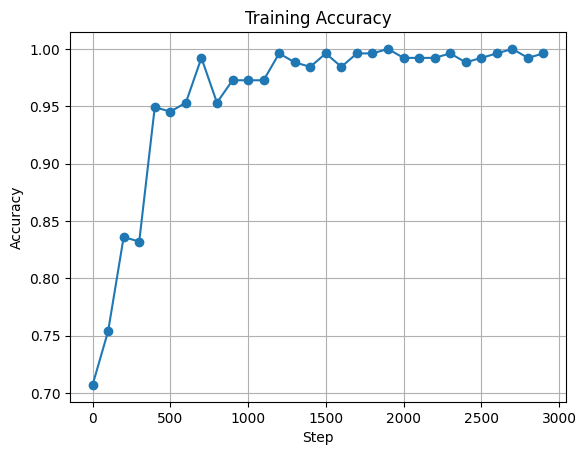

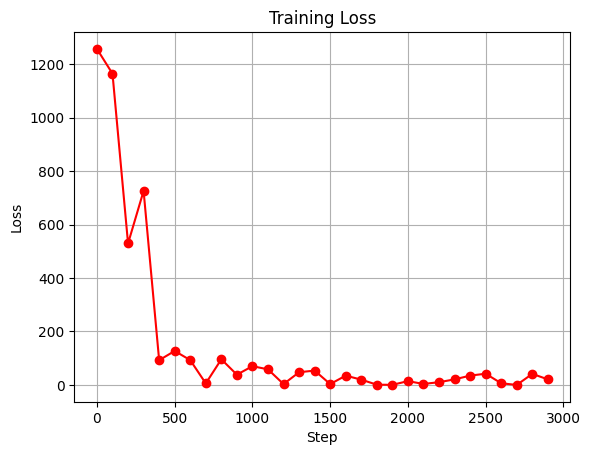

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(range(0, training_steps, display_step), accuracy_history, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

# Виведіть графік точності
plt.plot(range(0, training_steps, display_step), loss_history, marker='o', color='r')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid()
plt.show()


In [24]:
# Обчисліть точність навченої нейромережі
neural_net_train = neural_net(x_train)
print(f"Train accuracy: {accuracy(neural_net_train, y_train)*100:.2f}%")
# Тестування моделі на тестових даних
pred = neural_net(x_test)
print(f'Test Accuracy: {accuracy(pred, y_test)*100:.2f}%')


Train accuracy: 99.00%
Test Accuracy: 94.19%


True: 1 Predict: 1 True
True: 3 Predict: 3 True
True: 5 Predict: 5 True
True: 1 Predict: 8 False
True: 8 Predict: 8 True
True: 4 Predict: 4 True
True: 6 Predict: 6 True
True: 2 Predict: 2 True
True: 9 Predict: 9 True
True: 8 Predict: 8 True
True: 3 Predict: 3 True
True: 9 Predict: 9 True
True: 1 Predict: 1 True
True: 7 Predict: 7 True
True: 3 Predict: 3 True


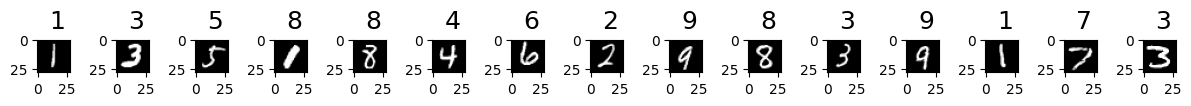

In [30]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

test_img = np.random.permutation(x_test.shape[0])[:15]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]
plt.figure(figsize=(12, 8))
for i in range(15):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 15, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap = "gray")
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()



Висновок: Побудована модель з оптимайзером Adam(Adaptive Moment Estimation)розпізнає рукописні малюнки з точністю 94.19%. При тесті на рандомних картинках вона правильно розпізнала 14 картинок з 15.

In [14]:
# Створимо щу один екземпляр нейронної мережі
neural_net1 = NN(name="mnist")

# Функція навчання нейромережі
# @tf.function
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)
  # optimizer = tf.optimizers.Adam(learning_rate)
  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [15]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net1, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net1(batch_x)
        batch_loss = cross_entropy(pred, batch_y)
        batch_accuracy = accuracy(pred, tf.cast(batch_y, tf.int64))
        loss_history.append(batch_loss)
        accuracy_history.append(batch_accuracy)

        print(f"Step {step}, Loss: {batch_loss}, Accuracy: {batch_accuracy}")


Step 100, Loss: 1283.481201171875, Accuracy: 0.671875
Step 200, Loss: 1171.7098388671875, Accuracy: 0.69140625
Step 300, Loss: 1366.4293212890625, Accuracy: 0.67578125
Step 400, Loss: 1137.39306640625, Accuracy: 0.7421875
Step 500, Loss: 227.67247009277344, Accuracy: 0.87109375
Step 600, Loss: 237.9947967529297, Accuracy: 0.8828125
Step 700, Loss: 151.36416625976562, Accuracy: 0.92578125
Step 800, Loss: 106.12666320800781, Accuracy: 0.94921875
Step 900, Loss: 142.4209442138672, Accuracy: 0.91015625
Step 1000, Loss: 67.49893951416016, Accuracy: 0.95703125
Step 1100, Loss: 118.67701721191406, Accuracy: 0.953125
Step 1200, Loss: 60.23808288574219, Accuracy: 0.9609375
Step 1300, Loss: 55.68587875366211, Accuracy: 0.94921875
Step 1400, Loss: 80.11604309082031, Accuracy: 0.96484375
Step 1500, Loss: 36.061988830566406, Accuracy: 0.96484375
Step 1600, Loss: 39.868988037109375, Accuracy: 0.98828125
Step 1700, Loss: 17.35051918029785, Accuracy: 0.98828125
Step 1800, Loss: 21.43118667602539, Accu

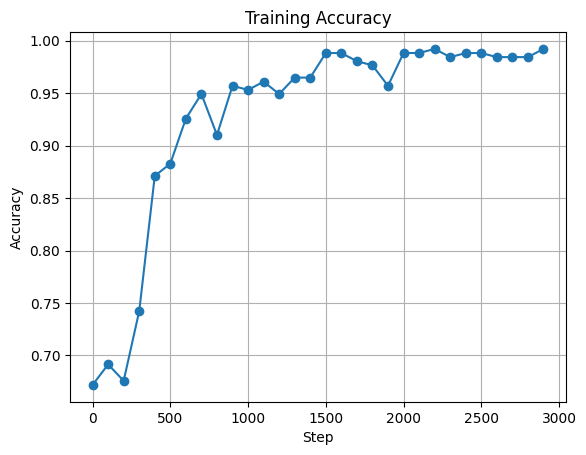

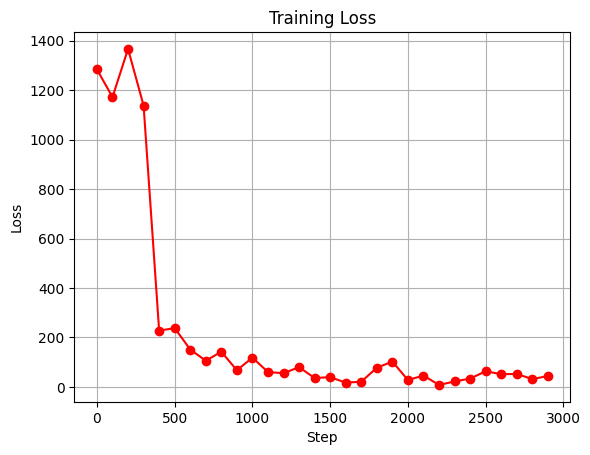

In [16]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(range(0, training_steps, display_step), accuracy_history, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

# Виведіть графік точності
plt.plot(range(0, training_steps, display_step), loss_history, marker='o', color='r')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [25]:
# Обчисліть точність навченої нейромережі
neural_net_train = neural_net1(x_train)
print(f"Train accuracy: {accuracy(neural_net_train, y_train)*100:.2f}%")
# Тестування моделі на тестових даних
pred = neural_net1(x_test)
print(f'Test Accuracy: {accuracy(pred, y_test)*100:.2f}%')

Train accuracy: 98.31%
Test Accuracy: 90.52%


True: 3 Predict: 3 True
True: 9 Predict: 9 True
True: 3 Predict: 3 True
True: 1 Predict: 1 True
True: 0 Predict: 0 True
True: 8 Predict: 8 True
True: 6 Predict: 5 False
True: 6 Predict: 6 True
True: 8 Predict: 8 True
True: 9 Predict: 4 False
True: 8 Predict: 8 True
True: 1 Predict: 1 True
True: 7 Predict: 7 True
True: 1 Predict: 1 True
True: 1 Predict: 1 True


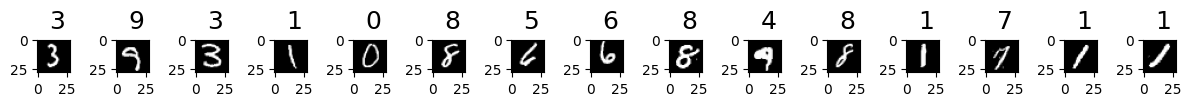

In [22]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

test_img = np.random.permutation(x_test.shape[0])[:15]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net1(x_test[test_img])]
plt.figure(figsize=(12, 8))
for i in range(15):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 15, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap = "gray")
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()


Висновок: Побудована модель з оптимайзером SGD(стохастичний градієнтний спуск) розпізнає рукописні малюнки з точністю 90.52%. При тесті на рандомних картинках вона правильно розпізнала 13 картинок з 15.

Модель з оптимайзером SGD(стохастичний градієнтний спуск) працює трохи гірше, ніж модель з оптимайзером Adam(Adaptive Moment Estimation), який розроблений для "глибоких" нейронних мереж. Але навчання моделі з оптимайзером SGD проходить в 2 рази швидше порівняно з моделью з оптимайзером Adam(2 хвилини проти 4 для данного датасету).